 Pratice1
---
지금까지 공부한 실습 내용을 이용하여 직접 데이터셋과 모델을 구축해서 Image classification을 수행하여 결과를 저장합니다. 처음엔 Train 데이터만 제공하고 이후에 test데이터를 배포했을때 저장한 모델을 불러와 테스트를 실시합니다.
이번 실습은 공부한 내용을 직접 구성해보는 것을 원칙으로 하며 다음 유의사항을 따라서 실습해주시길 바랍니다.

[Practice Dataset](https://drive.google.com/file/d/14q57qJ2YSuCwlfA8GFA0jHh6jBguNs3Q/view?usp=sharing)

실습시 유의사항
* Dataset을 직접 구축하여 사용합니다. (train/validation으로 구성), ImageFolder 사용 x
* DataArgumentation, Transform은 원하는대로 수행
* 구축한 Dataset을 이용하여 데이터로더에서 class별로 2개씩 시각화해서 확인
* activation 함수는 Custom Function로 직접 구축해서 작성 -> torch.nn.ReLU()와 같은방법으로 사용 x
* Model은 직접 구축하는것을 원칙으로 하나 github나 다른 사이트에서 참고해도 괜찮습니다.
* 사전학습된모델(pre-trained model)의 사용은 불가능합니다.
* torchvision, timm에 작성된 모델을 참고하는건 가능하지만 패키지로 사용하면 안됩니다.
    - torchvision.models.resnet18(weights=None) -> x
    - timm.create_model('resnet18', pretrained=False) -> x

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
import glob
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from torch.autograd import Function

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
import random

idx_for_divide = [i for i in range(0, 500)]
random.shuffle(idx_for_divide)
idx_for_train = idx_for_divide[:450]
idx_for_val = idx_for_divide[450:]

In [4]:
class myDataset(Dataset): 
  def __init__(self, path, phase, transform = None):
    self.path = path
    self.daisy_path = path + 'daisy'
    self.dandelion_path = path + 'dandelion'
    self.roses_path = path + 'roses'
    self.sunflowers_path = path + 'sunflowers'
    self.tulips_path = path + 'tulips'

    self.daisy_img_list = glob.glob(self.daisy_path + '/*.jpg')
    self.dandelion_img_list = glob.glob(self.dandelion_path + '/*.jpg')
    self.roses_img_list = glob.glob(self.roses_path + '/*.jpg')
    self.sunflowers_img_list = glob.glob(self.sunflowers_path + '/*.jpg')
    self.tulips_img_list = glob.glob(self.tulips_path + '/*.jpg')
    if phase == 'train':
      temp = []
      for i in idx_for_train:
        temp.append(self.daisy_img_list[i])
      self.daisy_img_list = temp

      temp = []
      for i in idx_for_train:
        temp.append(self.dandelion_img_list[i])
      self.dandelion_img_list = temp

      temp = []
      for i in idx_for_train:
        temp.append(self.roses_img_list[i])
      self.roses_img_list = temp

      temp = []
      for i in idx_for_train:
        temp.append(self.sunflowers_img_list[i])
      self.sunflowers_img_list = temp

      temp = []
      for i in idx_for_train:
        temp.append(self.tulips_img_list[i])
      self.tulips_img_list = temp
    elif phase == 'val':
      temp = []
      for i in idx_for_val:
        temp.append(self.daisy_img_list[i])
      self.daisy_img_list = temp

      temp = []
      for i in idx_for_val:
        temp.append(self.dandelion_img_list[i])
      self.dandelion_img_list = temp

      temp = []
      for i in idx_for_val:
        temp.append(self.roses_img_list[i])
      self.roses_img_list = temp

      temp = []
      for i in idx_for_val:
        temp.append(self.sunflowers_img_list[i])
      self.sunflowers_img_list = temp

      temp = []
      for i in idx_for_val:
        temp.append(self.tulips_img_list[i])
      self.tulips_img_list = temp
    else:
      pass
      
    self.transform = transform
    self.img_list = self.daisy_img_list + self.dandelion_img_list + self.roses_img_list + self.sunflowers_img_list + self.tulips_img_list
    self.class_list = [0]*len(self.daisy_img_list) + [1]*len(self.dandelion_img_list) + [2]*len(self.roses_img_list) + [3]*len(self.sunflowers_img_list) + [4]*len(self.tulips_img_list)
    


  def __len__(self): 
    return len(self.img_list)

  def __getitem__(self, idx): 
    img_path = self.img_list[idx]
    label = self.class_list[idx]
    img = Image.open(img_path)

    if self.transform is not None:
      img = self.transform(img)

    return img, label



In [5]:
transforms_train = transforms.Compose([
  # transforms.RandomResizedCrop(224),
  transforms.Resize((224,224)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [6]:
"""----------train dataset init-----------"""
train_dataset = myDataset('C:/Users/gnaro/Desktop/AJOU222_ITIP2_Practice/1031/train/', 'train', transforms_train)
train_dataset_size = len(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=False)

"""----------validation dataset init-----------"""
val_dataset = myDataset('C:/Users/gnaro/Desktop/AJOU222_ITIP2_Practice/1031/train/', 'val', transforms_val)
val_dataset_size = len(val_dataset)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=False)

"""----------dataloaders for train/val function-----------"""
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': train_dataset_size, 'val': val_dataset_size}

"""----------classes-----------"""
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

print("train dataset size: {}".format(train_dataset_size))
print("validation dataset size: {}".format(val_dataset_size))

train dataset size: 2250
validation dataset size: 250


In [7]:
"""test dataset init"""
test_dataset = myDataset('C:/Users/gnaro/Desktop/AJOU222_ITIP2_Practice/1031/test/', 'test', transforms_test)
test_dataset_size = len(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=False)

print("test dataset size: {}".format(test_dataset_size))

test dataset size: 500


Class별 2장 씩 보여주기

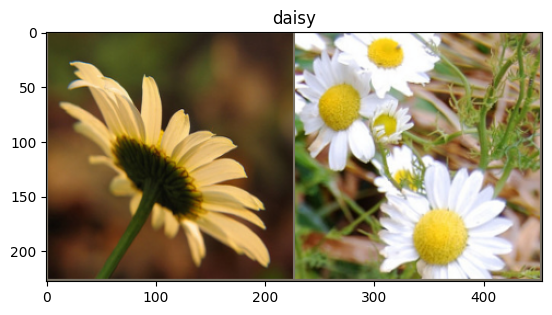

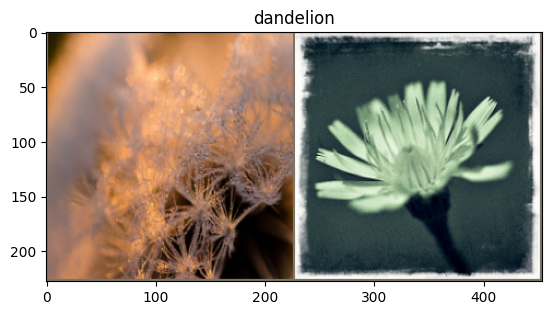

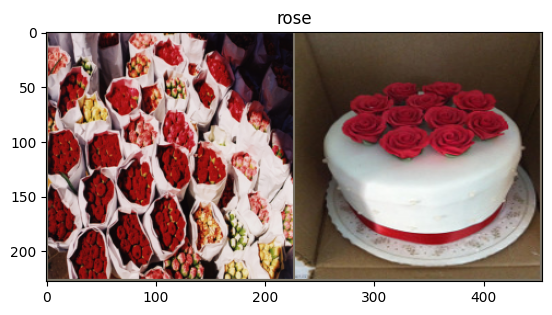

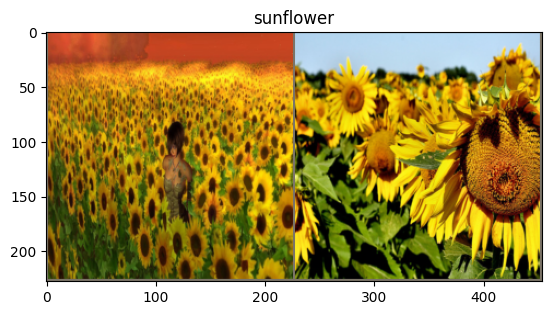

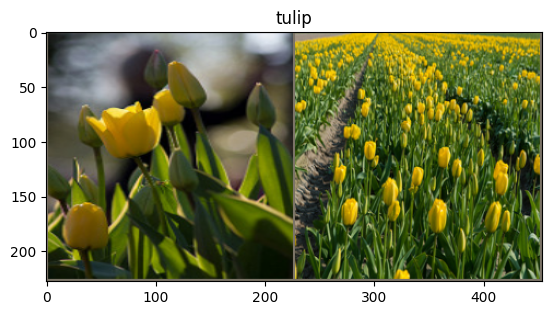

In [8]:
from torchvision.utils import make_grid

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

image_class_cnts = [0,0,0,0,0]
plot_images = [[],[],[],[],[]]
inputs, classes = next(iter(train_dataloader))
for i, c in zip(inputs, classes):
  if image_class_cnts[c] < 2:
    plot_images[c].append(i)
  image_class_cnts[c] += 1
inputs, classes = next(iter(train_dataloader))
for i, c in zip(inputs, classes):
  if image_class_cnts[c] < 2:
    plot_images[c].append(i)
  image_class_cnts[c] += 1

for i, img in enumerate(plot_images):
  out = make_grid(img)
  imshow(out, title=class_names[i])

In [9]:
"""----------my activation function(ReLU)----------"""
class myReLU(nn.Module):
  def __init__(self):
      super(myReLU, self).__init__()

  def forward(self, input):
      output = input.clamp(min=0)
      return output

In [10]:
"""
ResNet 구현을 위한 Code
Basick Block
"""
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            myReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        self.shortcut = nn.Sequential()
        self.af = myReLU()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.af(x)
        return x

In [11]:
"""
MyOjigoJirineunNet
"""
class MyOjigoJirineunNet(nn.Module):
    def __init__(self, block, num_block, num_classes=5, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            myReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights init
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def MOJN():
    return MyOjigoJirineunNet(BasicBlock, [2,2,2,2])


In [12]:
import copy
import time
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = MOJN()
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50)

Epoch 0/49
----------
train Loss: 0.8990 Acc: 0.6493
val Loss: 0.8689 Acc: 0.6720

Epoch 1/49
----------
train Loss: 0.8495 Acc: 0.6667
val Loss: 0.9323 Acc: 0.6360

Epoch 2/49
----------
train Loss: 0.8176 Acc: 0.6818
val Loss: 1.0590 Acc: 0.6240

Epoch 3/49
----------
train Loss: 0.7149 Acc: 0.7444
val Loss: 0.7240 Acc: 0.7760

Epoch 4/49
----------
train Loss: 0.6687 Acc: 0.7542
val Loss: 0.7317 Acc: 0.7560

Epoch 5/49
----------
train Loss: 0.6413 Acc: 0.7671
val Loss: 0.7188 Acc: 0.7600

Epoch 6/49
----------
train Loss: 0.6464 Acc: 0.7693
val Loss: 0.7197 Acc: 0.7560

Epoch 7/49
----------
train Loss: 0.6224 Acc: 0.7627
val Loss: 0.7153 Acc: 0.7480

Epoch 8/49
----------
train Loss: 0.5956 Acc: 0.7858
val Loss: 0.6891 Acc: 0.7600

Epoch 9/49
----------
train Loss: 0.5989 Acc: 0.7973
val Loss: 0.6767 Acc: 0.7440

Epoch 10/49
----------
train Loss: 0.5900 Acc: 0.7871
val Loss: 0.6630 Acc: 0.7600

Epoch 11/49
----------
train Loss: 0.5704 Acc: 0.7951
val Loss: 0.6572 Acc: 0.7800

Ep

In [20]:
def eval_model(model, test_data, criterion):
    since = time.time()

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    test_loss = running_loss / test_dataset_size
    test_acc = running_corrects.double() / test_dataset_size

    print(f'Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Test complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return

In [21]:
eval_model(model_ft, test_dataloader, criterion)

Loss: 0.6854 Acc: 0.7560
Test complete in 0m 3s


In [22]:
pytorch_total_params = sum(p.numel() for p in model_ft.parameters())
pytorch_total_params

11179077

In [23]:
from torchsummary import summary
summary(model_ft, (3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
            myReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            myReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
           myReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
           myReLU-14           [-1, 64,